# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [4]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [5]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [8]:
np.random.randn(1,4)

array([[ 0.67155854, -0.60469185, -0.24012786, -1.69451409]])

In [9]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
c=0
while True:
    c+=1
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
print(c)

Total score (averaged over agents) this episode: 0.13849999690428377
1001


When finished, you can close the environment.

In [7]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## 1. Using PPO
___

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [15]:
class ActorCritic(nn.Module):
    def __init__(self,input_size,output_size,std=0.0):
        super().__init__()
        
        self.actor = nn.Sequential(nn.Linear(input_size,32),
                                  nn.ReLU(),
                                  nn.Linear(32,16) ,
                                  nn.ReLU(),
                                  nn.Linear(16,output_size),
                                  nn.Tanh())
        self.critic = nn.Sequential(nn.Linear(input_size,64),
                                    nn.ReLU(),
                                    nn.Linear(64,32),
                                    nn.ReLU(),
                                    nn.Linear(32,1))
        self.log_std = nn.Parameter(torch.ones(1,output_size)*std)
    def forward(self,state):
        value = self.critic(state)
        mu = self.actor(state)
        std = self.log_std.exp()
        dist = Normal(mu,std)
        return dist,value

In [16]:
class ActorCritic(nn.Module):
    def __init__(self,input_size,output_size,std=0.0):
        super().__init__()
        
        self.actor = nn.Sequential(nn.Linear(input_size,16),
                                   nn.ReLU(),
                                  nn.Linear(16,output_size),
                                  nn.Tanh())
        self.critic = nn.Sequential(nn.Linear(input_size,16),
                                    nn.ReLU(),
                                    nn.Linear(16,1))
        self.log_std = nn.Parameter(torch.ones(1,output_size)*std)
    def forward(self,state):
        value = self.critic(state)
        mu = self.actor(state)
        std = self.log_std.exp()
        dist = Normal(mu,std)
        return dist,value

In [23]:
n_env = 8 
gamma = 0.99
lr = 1e-4
gae_lambda = 0.95
epsilon = 0.2
entropy_beta = 0.001
critic_discount = 0.5
PPO_STEPS = 512
mini_batch = 64
ppo_epochs = 10

def compute_gae(next_value,rewards,masks,values,gamma=gamma,lam=gae_lambda):
    values = values+[next_value]
    gae = 0 
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma*values[step+1]*masks[step] - values[step]
        gae = delta + gamma * lam * masks[step] *gae
        returns.insert(0,gae + values[step])
    return returns 

def normalize(x):
    x -= x.mean()
    x /= (x.std() + 1e-8)
    return x

    
def test_env(train_mode=False):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent
    while True:
        states = torch.FloatTensor(states)  
        dist,_ = model(states)                            # select an action (for each agent)
        actions = dist.sample().numpy()
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    
    return np.mean(scores)
    
    
def ppo_iter(states, actions, log_probs,advantage):
    batch_size = states.size(0)
    # generates random mini-batches until we have covered the full batch
    for _ in range(batch_size // mini_batch):
        rand_ids = np.random.randint(0, batch_size, mini_batch)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :],advantage[rand_ids, :]
    
    
    
    
def ppo_update(states,actions,log_probs,advantages,clip=epsilon):
    for ep in range(ppo_epochs):
        for state,action,old_log_prob,advantage in ppo_iter(states,actions,log_probs,advantages):
            dist,value = model(state)
            entropy = dist.entropy().mean()
            new_log_prob = dist.log_prob(action)
            
            ratio = (new_log_prob-old_log_prob).exp()
        
            surr1 = ratio*advantage
            surr2 = torch.clamp(ratio,1.0-clip,1.0+clip)*advantage
            
            actor_loss = -torch.min(surr1,surr2).mean()
            #critic_loss = (return_-value).pow(2).mean()
            critic_loss = advantage.pow(2).mean()
            
            loss = 0.5*critic_loss + actor_loss - entropy_beta*entropy
            
            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
            optimizer.step()
            
            return actor_loss.item(),critic_loss.item()

model = ActorCritic(state_size,action_size)
optimizer = optim.Adam(model.parameters(),lr=lr)



avg_last_100 = []
ac_loss = []
cr_loss = []
n_episodes = 100
best = 5
reward_per_ep = []
for ep in range(n_episodes):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations
    log_probs = []
    values = []
    states = []
    actions = []
    rewards = []
    masks = []
    score = 0
    c=0
    dones = []
    for i in range(PPO_STEPS):
        state = torch.FloatTensor(state)
        dist,value = model(state)
        action = dist.sample()
        env_info = env.step(np.clip(action.numpy(),-1,1))[brain_name]
        next_state = env_info.vector_observations
        reward = env_info.rewards
        done = env_info.local_done[0]
        log_prob = dist.log_prob(action)
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1))
        masks.append(torch.FloatTensor(1-done).unsqueeze(1))
        states.append(state)  
        actions.append(action)
        dones.append(torch.FloatTensor(1-done))
        state = next_state
        score += reward[0]
    
    #reward_per_ep.append(score)
    next_state = torch.FloatTensor(next_state)
    _,next_value = model(next_state)
    
    returns = compute_gae(next_value,rewards,masks,values)    
    
    returns   = torch.cat(returns).detach()                   
    rewards   = torch.cat(rewards)
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    
    advantage = returns - values
    advantage = normalize(advantage)
    actor_loss,critic_loss = ppo_update(states,actions,log_probs,advantage)
    ac_loss.append(actor_loss)
    cr_loss.append(critic_loss)
    
    
    score = test_env()
    reward_per_ep.append(score)
    print("\rEpisode {} , Score : {:3f}".format(ep+1,score),end="")
    if ep+1 > 100 :
        avg = np.mean(reward_per_ep[-100:])
        avg_last_100.append(avg)
        print(" Avg of last 100 : {:2f} ".format(avg),end="")
    if score> best:
        print("Best Reward updated ",best," =====> ",score)
        best = score  
        name = 'checkpoint_{}.pt'.format(best)
        torch.save(model.state_dict(),name)

Episode 100 , Score : 0.397500

In [ ]:
torch.save(model.state_dict(),'checkpoint_test.pt')

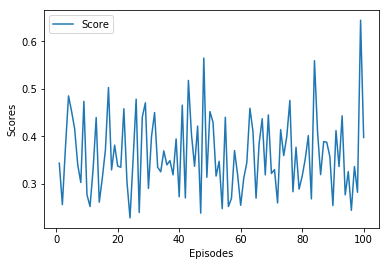

In [24]:
%matplotlib inline
X = np.arange(len(reward_per_ep))+1
plt.plot(X,reward_per_ep,label='Score')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.show()

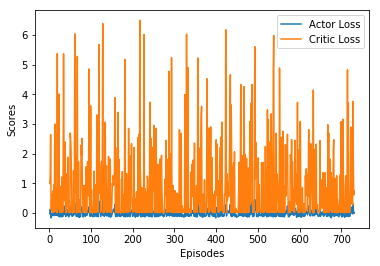

In [13]:
X = np.arange(len(reward_per_ep))+1
plt.plot(X,ac_loss,label='Actor Loss')
plt.plot(X,cr_loss,label='Critic Loss')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.show()

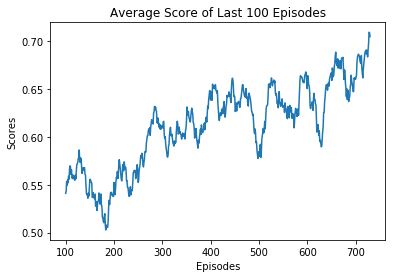

In [14]:
## Avg of last 100 
X = np.arange(len(avg_last_100))+100
plt.title("Average Score of Last 100 Episodes")
plt.plot(X,avg_last_100)
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.show()

## 2. using DDPG

In [10]:
from unityagents import UnityEnvironment
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from ddpg_agent import Agent
from ddpg_agent import Agent
import time
plt.ion()

In [11]:
import torch.nn.functional as F

In [9]:
seed = 42

# Create agent
agent = Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, seed=seed)

In [10]:
def ddpg(n_episodes=2000, max_t = 1000, window_size=100, score_threshold=30.0, 
         print_interval=10, epochs=1000):

    scores_deque = deque(maxlen=window_size)
    scores = []        
    best_average_score = -np.inf
    print("Training on {} started...".format(agent.device))
    
    for i_episode in range(1, epochs+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        episode_scores = np.zeros(num_agents) 

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)
            episode_scores += np.array(rewards)
            states = next_states
            if np.any(dones):
                break

        episode_score = np.mean(episode_scores) # Summary of scores for this episode
        scores_deque.append(episode_score)
        scores.append(episode_score)
        average_score = np.mean(scores_deque)

        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score), end="")
        if i_episode % print_interval == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score))

        if average_score >= score_threshold:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break      
    np.save('scores.npy', scores)
    return scores

In [11]:
scores = ddpg()

Training on cuda:0 started...
Episode: 10	Average Score: 0.75	Current Score: 0.98
Episode: 20	Average Score: 0.86	Current Score: 1.03
Episode: 30	Average Score: 1.09	Current Score: 1.76
Episode: 40	Average Score: 1.55	Current Score: 3.82
Episode: 50	Average Score: 2.14	Current Score: 4.66
Episode: 60	Average Score: 2.95	Current Score: 8.39
Episode: 70	Average Score: 3.94	Current Score: 11.66
Episode: 80	Average Score: 5.08	Current Score: 17.69
Episode: 90	Average Score: 6.80	Current Score: 22.66
Episode: 100	Average Score: 8.57	Current Score: 27.41
Episode: 110	Average Score: 11.36	Current Score: 29.92
Episode: 120	Average Score: 14.53	Current Score: 32.53
Episode: 130	Average Score: 17.75	Current Score: 32.77
Episode: 140	Average Score: 20.94	Current Score: 33.64
Episode: 150	Average Score: 24.13	Current Score: 37.14
Episode: 160	Average Score: 27.06	Current Score: 35.97
Episode: 170	Average Score: 29.65	Current Score: 35.82
Episode: 172	Average Score: 30.16	Current Score: 36.43
Envir

In [12]:
scores = np.load('scores.npy')

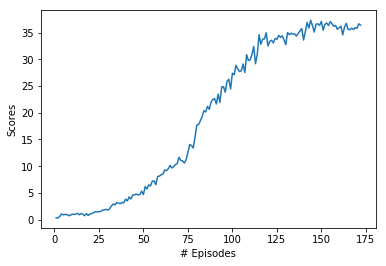

In [13]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('# Episodes')
plt.ylabel('Scores')   
plt.savefig('scores_plot.png')
plt.show()

In [ ]:
env.close()